# Introduction
### 🧾 Problem Statement
With the rapid rise in AI-generated visual content, distinguishing real-world driving scenes from synthetic ones is increasingly important for maintaining data integrity in autonomous driving systems. This notebook focuses on training a deep learning model that can accurately classify RGB images as either:

Real (label = 1)

Fake (label = 0)

___
### 📁 Dataset Overview  
Images are in JPEG format and in RGB color space.

Labels are provided for training data.

Test data is unlabeled and evaluated through a test dir.
___
### ⚙️ Objective
Preprocess the data.

Train a robust neural network model for binary classification.

Use transfer learning with pre-trained CNN architectures (Xception, EfficientNet, MobileNet, etc.) to boost performance.

Generate predictions for the test dataset and format them for submission.

# Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import collections
import cv2
from tensorflow.keras import layers
import random

from tensorflow.keras.applications import MobileNetV2, MobileNetV3Small ,EfficientNetB0,EfficientNetV2B0,Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load Data

In [ ]:
train_df = pd.read_csv('/content/train.csv')
train_df.head()

,image,label
0,1.jpg,editada
1,2.jpg,real
2,3.jpg,real
3,6.jpg,editada
4,8.jpg,real


In [ ]:
print(train_df.columns)


Index(['image', 'label'], dtype='object')


In [ ]:
train_df['label'] = train_df['label'].astype(str)


In [ ]:
class_counts=train_df['label'].value_counts()
print(class_counts)


label
real       405
editada    315
Name: count, dtype: int64


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest',
    validation_split=0.1

)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory='/content/Train',
    x_col='image',
    y_col='label',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=32,
    subset='training',
    shuffle=True
)


Found 648 validated image filenames belonging to 2 classes.


In [ ]:
val_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory='/content/Train',
    x_col='image',
    y_col='label',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=32,
    subset='validation',
    shuffle=False  )

Found 72 validated image filenames belonging to 2 classes.


In [ ]:
test_images = []
image_names = []
test_dir="/content/Test"
for filename in sorted(os.listdir(test_dir)):
    if filename.endswith('.jpg'):
        img_path = os.path.join(test_dir, filename)
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        test_images.append(img_array)
        image_names.append(filename)

X_test = np.array(test_images)

# Some Analysis

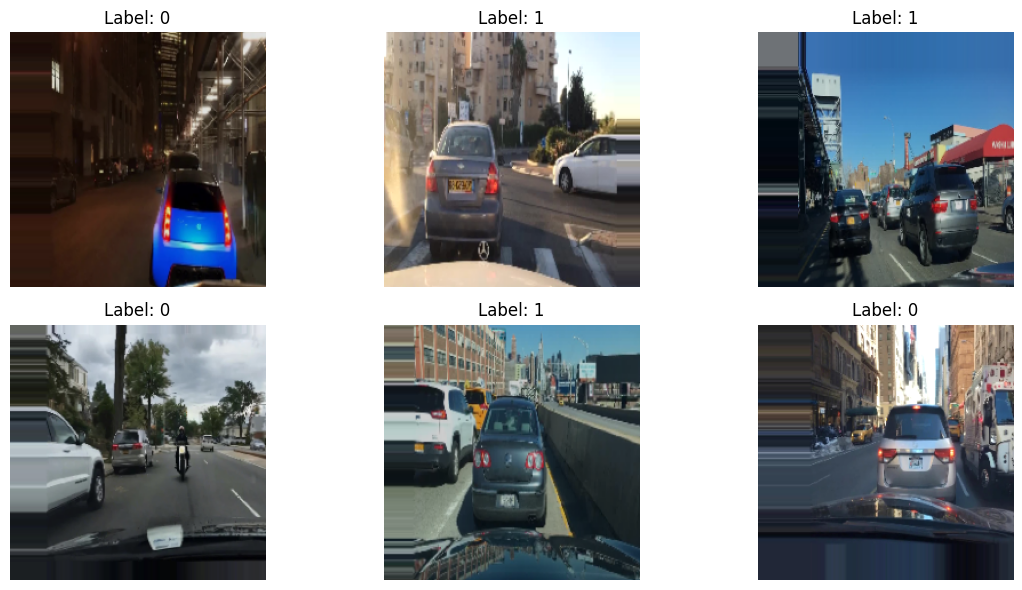

In [ ]:
images, labels = next(train_generator)
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

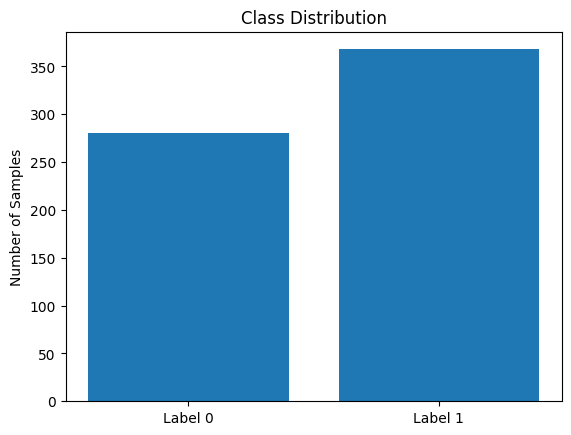

In [ ]:
labels_list = []
num_batches = len(train_generator)

for _ in range(num_batches):
    _, labels = next(train_generator)
    labels_list.extend(labels)

label_counts = collections.Counter(labels_list)

plt.bar(['Label 0', 'Label 1'], [label_counts[0], label_counts[1]])
plt.title('Class Distribution')
plt.ylabel('Number of Samples')
plt.show()

it is slightly imbalanced

In [ ]:
total = len(train_df)
percentages = (class_counts / total) * 100

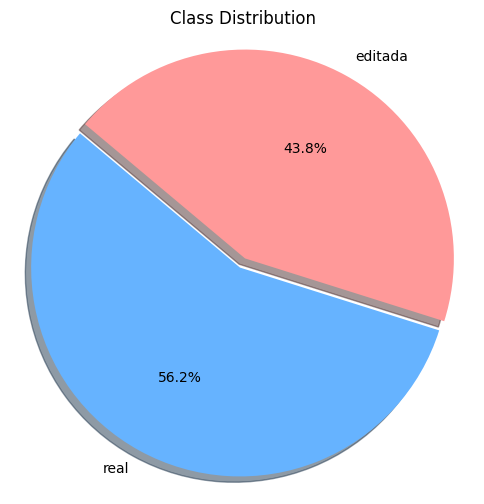

In [ ]:
labels = class_counts.index
sizes = class_counts.values
colors = ['#66b3ff', '#ff9999']
explode = (0.05, 0)
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140,
        colors=colors, explode=explode, shadow=True)
plt.title('Class Distribution')
plt.axis('equal')
plt.show()

# Modeling

## mobilevnet2

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))


In [ ]:
checkpoint_cb = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)


In [ ]:
history_v2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[checkpoint_cb],
    class_weight=class_weight_dict
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.4753 - loss: 0.8588
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.4764 - loss: 0.8575 - val_accuracy: 0.5000 - val_loss: 0.7594
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.4971 - loss: 0.7747
Epoch 2: val_accuracy improved from 0.50000 to 0.56944, saving model to best_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 617ms/step - accuracy: 0.4973 - loss: 0.7755 - val_accuracy: 0.5694 - val_loss: 0.7139
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.4951 - loss: 0.8300
Epoch 3: val_accuracy did not improve from 0.56944
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 592ms/step - accuracy: 0.4950 - loss: 0.8296 - val_accuracy: 0.4722 - val_loss: 0.7369
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.4912 - loss: 0.8116
Epoch 4: val_accuracy did not improve from 0.56944
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 614ms/step - accuracy: 0.4918 - loss: 0.8113 - val_accuracy: 0.4444 - val_loss: 0.7739
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.4771 - loss: 0.8513
Epoch 5: val_accuracy did not improve from 0.56944
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 605ms/step - accuracy: 0.4791 - loss: 0.8485 - val_accuracy: 0.4722 - val_loss: 0.7416
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.5163 - loss: 0.7717
Epoch 6: val_accuracy did not i

In [ ]:
best_model = load_model('best_model.h5')

In [ ]:
loss, accuracy = best_model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 738ms/step - accuracy: 0.4579 - loss: 0.7958
Validation Accuracy: 0.4861, Loss: 0.7814


In [ ]:
preds = best_model.predict(X_test)
predicted_labels = (preds > 0.5).astype(int).flatten()

submission_df = pd.DataFrame({
    'image': image_names,
    'label': predicted_labels
})
submission_df.to_csv('submission_mobile.csv', index=False)


6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 854ms/step


## mobilevnet3small


In [ ]:
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

checkpoint_cb = ModelCheckpoint(
    'best_mobilenetv3_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history_v3small = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[checkpoint_cb],
    class_weight=class_weight_dict
)


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.4454 - loss: 0.7359
Epoch 1: val_accuracy improved from -inf to 0.45833, saving model to best_mobilenetv3_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4453 - loss: 0.7357 - val_accuracy: 0.4583 - val_loss: 0.7303
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.4294 - loss: 0.7370
Epoch 2: val_accuracy did not improve from 0.45833
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 579ms/step - accuracy: 0.4303 - loss: 0.7366 - val_accuracy: 0.4583 - val_loss: 0.7139
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.4904 - loss: 0.7071
Epoch 3: val_accuracy did not improve from 0.45833
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 583ms/step - accuracy: 0.4899 - loss: 0.7072 - val_accuracy: 0.4583 - val_loss: 0.7046
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.4968 - loss: 0.7001
Epoch 4: val_accuracy did not improve from 0.45833
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 582ms/step - accuracy: 0.4976 - loss: 0.6999 - val_accuracy: 0.4583 - val_loss: 0.6997
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.4743 - loss: 0.7106
Epoch 5: val_accuracy did not impr

21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 596ms/step - accuracy: 0.4901 - loss: 0.7026 - val_accuracy: 0.5694 - val_loss: 0.6928
Epoch 9/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.5055 - loss: 0.7051
Epoch 9: val_accuracy did not improve from 0.56944
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 586ms/step - accuracy: 0.5044 - loss: 0.7051 - val_accuracy: 0.5000 - val_loss: 0.6923
Epoch 10/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.5141 - loss: 0.7034
Epoch 10: val_accuracy did not improve from 0.56944
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 583ms/step - accuracy: 0.5142 - loss: 0.7031 - val_accuracy: 0.4444 - val_loss: 0.6937
Epoch 11/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.4910 - loss: 0.7137
Epoch 11: val_accuracy improved from 0.56944 to 0.58333, saving model to best_mobilenetv3_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 582ms/step - accuracy: 0.4913 - loss: 0.7135 - val_accuracy: 0.5833 - val_loss: 0.6917
Epoch 12/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.4651 - loss: 0.7071
Epoch 12: val_accuracy did not improve from 0.58333
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 580ms/step - accuracy: 0.4675 - loss: 0.7068 - val_accuracy: 0.5833 - val_loss: 0.6927
Epoch 13/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.4926 - loss: 0.7076
Epoch 13: val_accuracy did not improve from 0.58333
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 574ms/step - accuracy: 0.4926 - loss: 0.7077 - val_accuracy: 0.5833 - val_loss: 0.6928
Epoch 14/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.4653 - loss: 0.7087
Epoch 14: val_accuracy did not improve from 0.58333
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 587ms/step - accuracy: 0.4657 - loss: 0.7088 - val_accuracy: 0.5417 - val_loss: 0.6927
Epoch 15/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.4703 - loss: 0.7010
Epoch 15: val_accuracy d

## effiecntnetb0

In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x= layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x= layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

checkpoint_cb = ModelCheckpoint(
    'effcientb0_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return (lr * tf.math.exp(-0.1)).numpy()

history_efficent = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[checkpoint_cb, tf.keras.callbacks.LearningRateScheduler(scheduler)],
    class_weight=class_weight_dict
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
20/21 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5284 - loss: 2.7744
Epoch 1: val_accuracy improved from -inf to 0.45833, saving model to effcientb0_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5267 - loss: 2.7518 - val_accuracy: 0.4583 - val_loss: 1.9780 - learning_rate: 0.0010
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.5220 - loss: 1.8091
Epoch 2: val_accuracy improved from 0.45833 to 0.54167, saving model to effcientb0_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 616ms/step - accuracy: 0.5218 - loss: 1.8029 - val_accuracy: 0.5417 - val_loss: 1.3731 - learning_rate: 0.0010
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.4766 - loss: 1.3079
Epoch 3: val_accuracy did not improve from 0.54167
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 591ms/step - accuracy: 0.4760 - loss: 1.3043 - val_accuracy: 0.5417 - val_loss: 1.0735 - learning_rate: 0.0010
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.5129 - loss: 1.0449
Epoch 4: val_accuracy did not improve from 0.54167
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 597ms/step - accuracy: 0.5123 - loss: 1.0430 - val_accuracy: 0.4583 - val_loss: 0.9325 - learning_rate: 0.0010
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.5403 - loss: 0.9090
Epoch 5: val_accuracy did not improve from 0.54167
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 601ms/step - accuracy: 0.5391 - loss: 0.9085 - val_accuracy: 0.4583 - val_loss: 0.8779 - learning_rate: 0.0010
Epoch 6/15
21/21 ━━━━

In [ ]:
effcientb0_model = load_model('effcientb0_model.h5')
loss, accuracy = effcientb0_model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5404 - loss: 1.3735
Validation Accuracy: 0.5417, Loss: 1.3731


In [ ]:
preds = effcientb0_model.predict(X_test)
predicted_labels = (preds > 0.5).astype(int).flatten()

submission_df = pd.DataFrame({
    'image': image_names,
    'label': predicted_labels
})
submission_df.to_csv('submission_effic.csv', index=False)


6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step


## efficentv2

In [ ]:
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x= layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

checkpoint_cb = ModelCheckpoint(
    'effcientv2b0_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='min',
    verbose=1
)
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return (lr * tf.math.exp(-0.1)).numpy()

history_efficentv2b0 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[checkpoint_cb, tf.keras.callbacks.LearningRateScheduler(scheduler)],
    class_weight=class_weight_dict
)


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4822 - loss: 0.7067
Epoch 1: val_accuracy improved from inf to 0.45833, saving model to effcientv2b0_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.4827 - loss: 0.7067 - val_accuracy: 0.4583 - val_loss: 0.6948 - learning_rate: 0.0010
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.5041 - loss: 0.7016
Epoch 2: val_accuracy did not improve from 0.45833
21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 592ms/step - accuracy: 0.5046 - loss: 0.7018 - val_accuracy: 0.4583 - val_loss: 0.6977 - learning_rate: 0.0010
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.4635 - loss: 0.7134
Epoch 3: val_accuracy did not improve from 0.45833
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 587ms/step - accuracy: 0.4648 - loss: 0.7132 - val_accuracy: 0.5417 - val_loss: 0.6911 - learning_rate: 0.0010
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.5012 - loss: 0.6986
Epoch 4: val_accuracy did not improve from 0.45833
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 593ms/step - accuracy: 0.5018 - loss: 0.6986 - val_accuracy: 0.4583 - val_loss: 0.7035 - learning_rate: 0.0010
Epoch 5/15
21/21 ━━━━━━━

In [ ]:
effcientv2b0_model = load_model('effcientv2b0_model.h5')
loss, accuracy = effcientv2b0_model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4596 - loss: 0.6945
Validation Accuracy: 0.4583, Loss: 0.6946


## xception


In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu',kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

checkpoint_cb = ModelCheckpoint(
    'xceptionl.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
history_xception = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[checkpoint_cb],
    class_weight=class_weight_dict
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5760 - loss: 11.2995
Epoch 1: val_loss improved from inf to 4.13849, saving model to xceptionl.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.5771 - loss: 11.1785 - val_accuracy: 0.4583 - val_loss: 4.1385
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.6367 - loss: 2.6734
Epoch 2: val_loss improved from 4.13849 to 1.75772, saving model to xceptionl.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 800ms/step - accuracy: 0.6371 - loss: 2.6403 - val_accuracy: 0.5000 - val_loss: 1.7577
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.6395 - loss: 0.8853
Epoch 3: val_loss did not improve from 1.75772
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 716ms/step - accuracy: 0.6401 - loss: 0.8810 - val_accuracy: 0.4444 - val_loss: 6.6190
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.7280 - loss: 0.5847
Epoch 4: val_loss improved from 1.75772 to 1.25358, saving model to xceptionl.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 876ms/step - accuracy: 0.7285 - loss: 0.5842 - val_accuracy: 0.7639 - val_loss: 1.2536
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.8316 - loss: 0.4537
Epoch 5: val_loss did not improve from 1.25358
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 710ms/step - accuracy: 0.8307 - loss: 0.4544 - val_accuracy: 0.6250 - val_loss: 20.9925
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.7908 - loss: 0.5076
Epoch 6: val_loss did not improve from 1.25358
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 729ms/step - accuracy: 0.7913 - loss: 0.5067 - val_accuracy: 0.4583 - val_loss: 12.8414
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.8529 - loss: 0.3940
Epoch 7: val_loss did not improve from 1.25358
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 719ms/step - accuracy: 0.8536 - loss: 0.3932 - val_accuracy: 0.7500 - val_loss: 5.5926
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.8517 - loss: 0.4173
Epoch 8: val_loss did not improve from 1.

21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 892ms/step - accuracy: 0.9134 - loss: 0.2282 - val_accuracy: 0.8056 - val_loss: 0.7425
Epoch 14/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.9644 - loss: 0.1460
Epoch 14: val_loss did not improve from 0.74249
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 722ms/step - accuracy: 0.9639 - loss: 0.1467 - val_accuracy: 0.7639 - val_loss: 0.8376
Epoch 15/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.9569 - loss: 0.1476
Epoch 15: val_loss improved from 0.74249 to 0.60567, saving model to xceptionl.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 795ms/step - accuracy: 0.9567 - loss: 0.1486 - val_accuracy: 0.8056 - val_loss: 0.6057


In [ ]:
xceptionl = load_model('xceptionl.h5')
loss, accuracy = xceptionl.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 959ms/step - accuracy: 0.8377 - loss: 0.6252
Validation Accuracy: 0.8472, Loss: 0.5676


In [ ]:
preds = model.predict(X_test)
predicted_labels = (preds > 0.5).astype(int).flatten()

submission_df = pd.DataFrame({
    'image': image_names,
    'label': predicted_labels
})
submission_df.to_csv('submission_xc.csv', index=False)


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = layers.Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

checkpoint_cb = ModelCheckpoint(
    'xceptionl2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
history_xception2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[checkpoint_cb],
    class_weight=class_weight_dict
)

Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4717 - loss: 4.1771
Epoch 1: val_loss improved from inf to 0.69567, saving model to xceptionl2.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.4707 - loss: 4.0802 - val_accuracy: 0.4583 - val_loss: 0.6957
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.4162 - loss: 0.6905
Epoch 2: val_loss improved from 0.69567 to 0.69469, saving model to xceptionl2.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.4170 - loss: 0.6907 - val_accuracy: 0.4583 - val_loss: 0.6947
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.4317 - loss: 0.6929
Epoch 3: val_loss did not improve from 0.69469
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 788ms/step - accuracy: 0.4318 - loss: 0.6930 - val_accuracy: 0.4583 - val_loss: 0.6949
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.4332 - loss: 0.6931
Epoch 4: val_loss improved from 0.69469 to 0.69425, saving model to xceptionl2.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 96s 5s/step - accuracy: 0.4333 - loss: 0.6932 - val_accuracy: 0.4583 - val_loss: 0.6942
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.4198 - loss: 0.6908
Epoch 5: val_loss improved from 0.69425 to 0.69375, saving model to xceptionl2.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.4205 - loss: 0.6910 - val_accuracy: 0.4583 - val_loss: 0.6938
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.4479 - loss: 0.6951
Epoch 6: val_loss did not improve from 0.69375
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 707ms/step - accuracy: 0.4473 - loss: 0.6950 - val_accuracy: 0.4583 - val_loss: 0.6940
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.4330 - loss: 0.6927
Epoch 7: val_loss did not improve from 0.69375
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 723ms/step - accuracy: 0.4331 - loss: 0.6928 - val_accuracy: 0.4583 - val_loss: 0.6940
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.4554 - loss: 0.6966
Epoch 8: val_loss did not improve from 0.69375
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 780ms/step - accuracy: 0.4544 - loss: 0.6964 - val_accuracy: 0.4583 - val_loss: 0.6940
Epoch 9/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.4049 - loss: 0.6885
Epoch 9: val_loss improved from 0.69375 to 0.6

21/21 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.4062 - loss: 0.6888 - val_accuracy: 0.4583 - val_loss: 0.6934
Epoch 10/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.4659 - loss: 0.6993
Epoch 10: val_loss did not improve from 0.69342
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 710ms/step - accuracy: 0.4644 - loss: 0.6991 - val_accuracy: 0.4583 - val_loss: 0.6936
Epoch 11/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.4446 - loss: 0.6944
Epoch 11: val_loss did not improve from 0.69342
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 740ms/step - accuracy: 0.4442 - loss: 0.6944 - val_accuracy: 0.4583 - val_loss: 0.6935
Epoch 12/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.4188 - loss: 0.6906
Epoch 12: val_loss improved from 0.69342 to 0.69335, saving model to xceptionl2.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.4199 - loss: 0.6907 - val_accuracy: 0.4583 - val_loss: 0.6934
Epoch 13/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.4449 - loss: 0.6968
Epoch 13: val_loss did not improve from 0.69335
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 718ms/step - accuracy: 0.4443 - loss: 0.6967 - val_accuracy: 0.4583 - val_loss: 0.6935
Epoch 14/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.4250 - loss: 0.6947
Epoch 14: val_loss did not improve from 0.69335
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 727ms/step - accuracy: 0.4250 - loss: 0.6946 - val_accuracy: 0.4583 - val_loss: 0.6934
Epoch 15/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.4199 - loss: 0.6951
Epoch 15: val_loss improved from 0.69335 to 0.69334, saving model to xceptionl2.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.4205 - loss: 0.6950 - val_accuracy: 0.4583 - val_loss: 0.6933


In [ ]:
xceptionl2 = load_model('xceptionl2.h5')
loss, accuracy = xceptionl2.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 756ms/step - accuracy: 0.4596 - loss: 0.6933
Validation Accuracy: 0.4583, Loss: 0.6933


# Results

In [ ]:
def plot_model_histories(histories, model_names):
    plt.figure(figsize=(16, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} - Train')
        plt.plot(history.history['val_accuracy'], label=f'{name} - Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} - Train')
        plt.plot(history.history['val_loss'], label=f'{name} - Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


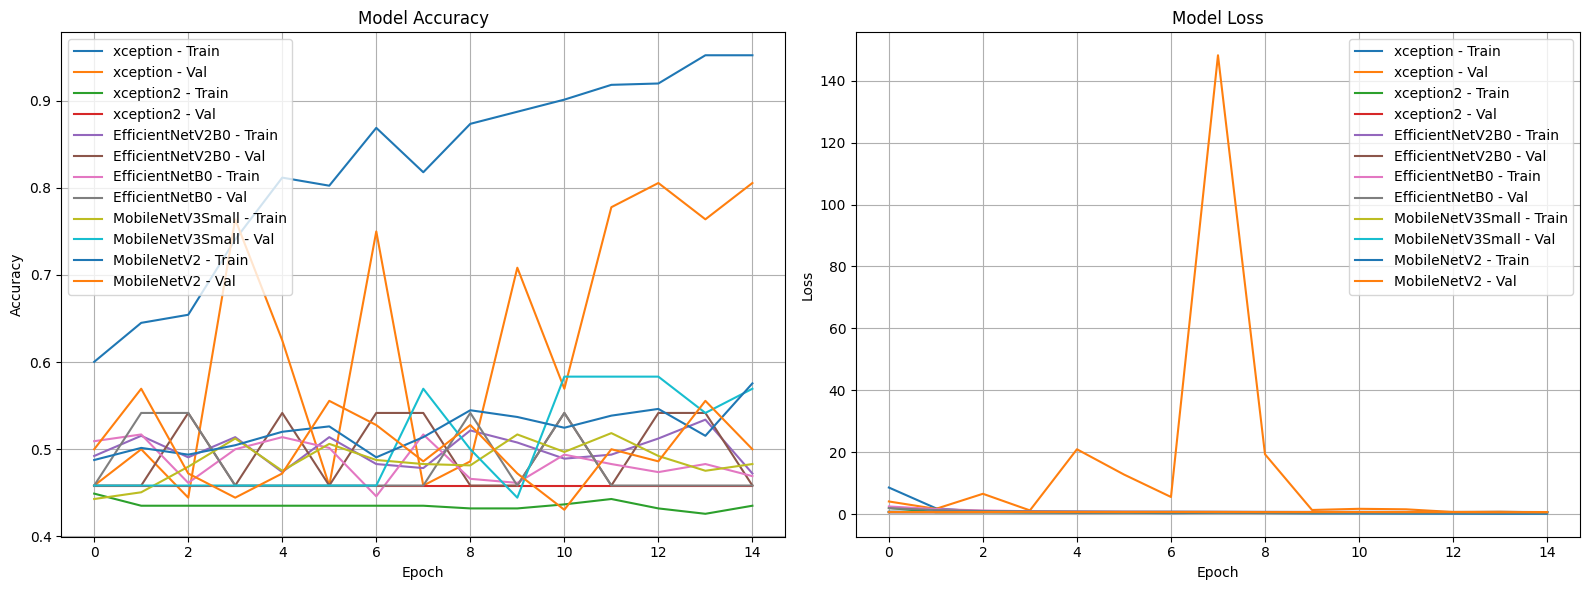

In [ ]:
plot_model_histories(
    histories=[history_xception, history_xception2,history_efficentv2b0,history_efficent,history_v3small,history_v2],
    model_names=['xception', 'xception2','EfficientNetV2B0','EfficientNetB0','MobileNetV3Small','MobileNetV2']
)


In [ ]:
preds = xceptionl.predict(X_test)
predicted_labels = (preds > 0.5).astype(int).flatten()

submission_df = pd.DataFrame({
    'image': image_names,
    'label': predicted_labels
})

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 561ms/step


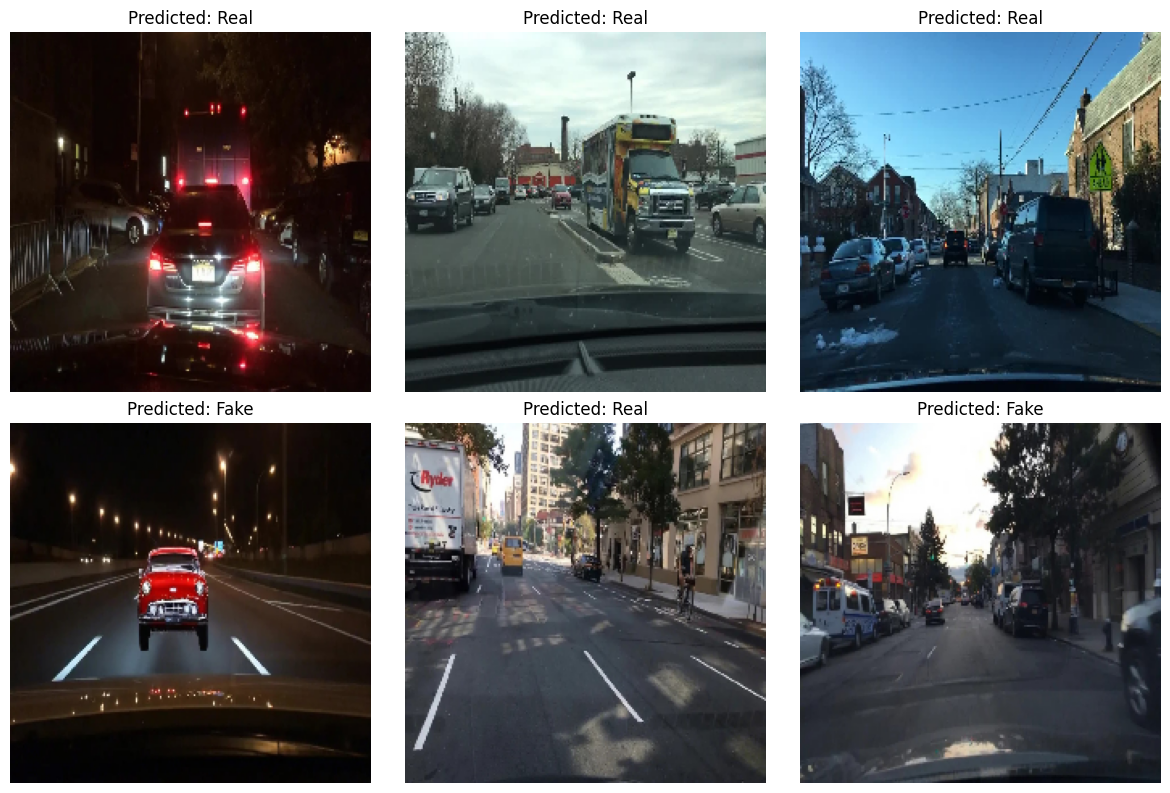

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_test[i])
    plt.title(f"Predicted: {'Real' if predicted_labels[i] == 1 else 'Fake'}")
    plt.axis('off')
plt.tight_layout()
plt.show()